In [1]:
%cd ../..

/home/dmoreno/ATAT_ZTF/elasticc_one


# Confusion matrices

In [3]:
import os
import json 
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

/home/dmoreno/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [27]:
path_data = './data/final/ZTF_ff/LC_MD_FEAT_v3_fixed_logspace_200'
path_results = './results/ZTF/LC_MD_FEAT/lc_md_feat_mta_v3_fixed_logspace/MTA'
time_to_eval = 2048

order_classes = ['SNIa', # yes
                 'SNIbc', # yes
                 'SNIIb', # yes
                 'SNII', # yes
                 'SNIIn', # yes
                 'SLSN', # yes
                 'TDE', # yes
                 'Microlensing', # yes
                 'QSO', 
                 'AGN', # yes
                 'Blazar', 
                 'YSO', 
                 'CV/Nova', 
                 'LPV', 
                 'EA', 
                 'EB/EW', # yes
                 'Periodic-Other', 
                 'RSCVn', 
                 'CEP', 
                 'RRLab', 
                 'RRLc', 
                 'DSCT']

In [28]:
objects_partitions = pd.read_parquet('./data/partitions/v3/partitions.parquet')
obj_label = objects_partitions[objects_partitions['partition'] == 'test']
y_real_test = obj_label['alerceclass'].values
obj_label = [x.encode('utf-8') for x in obj_label['oid'].values]
obj_label

[b'ZTF18adldhip',
 b'ZTF19aasbgeb',
 b'ZTF18aayfbqd',
 b'ZTF19ablyzbl',
 b'ZTF18actabfv',
 b'ZTF18aaztkvq',
 b'ZTF21aaphzsw',
 b'ZTF19aarhrcv',
 b'ZTF17aaajmxw',
 b'ZTF18acrvact',
 b'ZTF22aaahdyl',
 b'ZTF18aacebav',
 b'ZTF19abnqhwd',
 b'ZTF19abjgdow',
 b'ZTF18abklljv',
 b'ZTF18aalaphh',
 b'ZTF23aaaziou',
 b'ZTF17aacihzd',
 b'ZTF22abnmzar',
 b'ZTF17aaaoite',
 b'ZTF18abcurfb',
 b'ZTF18adbbyzu',
 b'ZTF18aaxpqts',
 b'ZTF18aacgwxk',
 b'ZTF18admcecv',
 b'ZTF18abukrnx',
 b'ZTF19aapuibt',
 b'ZTF18aawccep',
 b'ZTF21aahfpup',
 b'ZTF19aaoztzf',
 b'ZTF18aayijfg',
 b'ZTF18abgpcbj',
 b'ZTF18abwbiev',
 b'ZTF18actawil',
 b'ZTF20abyzomt',
 b'ZTF17aabxqbf',
 b'ZTF18abukymf',
 b'ZTF18abvbsoc',
 b'ZTF18actunfi',
 b'ZTF18aazfeau',
 b'ZTF22aaayewi',
 b'ZTF18aaxtcdl',
 b'ZTF18abtoxjw',
 b'ZTF18acdpxfb',
 b'ZTF18aabvmax',
 b'ZTF18abbogne',
 b'ZTF18aapnlus',
 b'ZTF18abmawit',
 b'ZTF19abbxyxi',
 b'ZTF18abscchv',
 b'ZTF18abusyzs',
 b'ZTF18abolzdx',
 b'ZTF19abjbaml',
 b'ZTF18acwuhrk',
 b'ZTF20aasokxu',
 b'ZTF18ac

In [29]:
y_real_test.shape

(8346,)

In [30]:
len(obj_label)

8346

In [31]:
import yaml

def load_yaml(path):
    with open(path, 'r') as file:
        args = yaml.load(file, Loader=yaml.FullLoader)
    return args

dict_info = load_yaml('{}/dict_info.yaml'.format(path_data))

mapping_classes = dict_info['mapping_classes']
mapping_classes_inverted = {v: k for k, v in mapping_classes.items()}
print(mapping_classes_inverted)

{0: 'AGN', 8: 'Blazar', 12: 'CEP', 5: 'CV/Nova', 15: 'DSCT', 2: 'EA', 10: 'EB/EW', 11: 'LPV', 21: 'Microlensing', 14: 'Periodic-Other', 1: 'QSO', 13: 'RRLab', 6: 'RRLc', 7: 'RSCVn', 17: 'SLSN', 9: 'SNII', 19: 'SNIIb', 20: 'SNIIn', 4: 'SNIa', 16: 'SNIbc', 18: 'TDE', 3: 'YSO'}


In [32]:
def sort_dict_by_value(d, reverse=False):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=reverse))

sort_classes = list(sort_dict_by_value(mapping_classes).keys())
print(sort_classes)

['AGN', 'QSO', 'EA', 'YSO', 'SNIa', 'CV/Nova', 'RRLc', 'RSCVn', 'Blazar', 'SNII', 'EB/EW', 'LPV', 'CEP', 'RRLab', 'Periodic-Other', 'DSCT', 'SNIbc', 'SLSN', 'TDE', 'SNIIb', 'SNIIn', 'Microlensing']


In [33]:
predictions = torch.load('{}/all_predictions_times.pt'.format(path_results))
predictions

{'SNID': array([b'ZTF17aaaecgi', b'ZTF17aaaedvi', b'ZTF17aaafglk', ...,
        b'ZTF23aamxeoe', b'ZTF23aavxvsz', b'ZTF23abcvqkd'], dtype=object),
 'y_test': tensor([10, 11,  5,  ..., 20,  4,  4]),
 'list_y_pred': {'test_16': array([ 2, 11,  5, ...,  4,  4, 19]),
  'test_32': array([10, 11,  5, ...,  4,  4, 16]),
  'test_64': array([10, 11,  5, ..., 17,  4, 16]),
  'test_128': array([10, 11,  5, ..., 20,  4, 16]),
  'test_256': array([10, 11,  5, ..., 20,  4, 16]),
  'test_512': array([10, 11,  5, ..., 20,  4, 16]),
  'test_1024': array([10, 11,  5, ..., 20,  4, 16]),
  'test_2048': array([10, 11,  5, ..., 20,  4,  5])},
 'list_y_pred_prob': {'test_16': array([[9.8516866e-09, 4.1721746e-09, 8.8548291e-01, ..., 1.6731694e-10,
          8.5009616e-10, 1.1424041e-11],
         [2.4245704e-08, 5.5073063e-08, 2.3116991e-05, ..., 4.5971733e-09,
          7.5336493e-10, 1.0665801e-11],
         [1.7835908e-05, 1.9082135e-04, 6.7266230e-03, ..., 4.2987941e-03,
          5.7440648e-05, 4.702448

In [34]:
predictions['list_y_pred_prob']['test_2048'].shape

(41728, 22)

In [35]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob'])

In [36]:
predictions['y_test'].shape

torch.Size([41728])

In [37]:
predictions['SNID'].shape

(41728,)

In [38]:
predictions['labels_final'] = predictions['y_test']
predictions['ids_final'] = np.array(predictions['SNID'])
print(predictions['labels_final'].shape)

df_atat_pred = []

for eval_time, prob_classes in predictions['list_y_pred_prob'].items():
    df = pd.DataFrame(prob_classes, columns=sort_classes)
    df['shorten'] = str(eval_time.split('_')[-1])
    df.index = predictions['ids_final']
    df_atat_pred.append(df)

df_atat_pred = pd.concat(df_atat_pred)
df_atat_pred

torch.Size([41728])


,AGN,QSO,EA,YSO,SNIa,CV/Nova,RRLc,RSCVn,Blazar,SNII,...,RRLab,Periodic-Other,DSCT,SNIbc,SLSN,TDE,SNIIb,SNIIn,Microlensing,shorten
b'ZTF17aaaecgi',9.851687e-09,4.172175e-09,8.854829e-01,3.253593e-03,1.912204e-07,0.000038,6.180049e-04,1.567360e-05,5.089462e-08,2.707900e-08,...,2.008267e-04,4.328849e-07,2.478666e-04,9.694603e-09,1.475338e-11,3.806151e-11,1.673169e-10,8.500962e-10,1.142404e-11,16
b'ZTF17aaaedvi',2.424570e-08,5.507306e-08,2.311699e-05,2.032680e-03,1.107568e-06,0.000322,1.194192e-06,7.084630e-06,1.792137e-07,2.195074e-06,...,2.776646e-05,3.500389e-05,9.745372e-06,1.575037e-08,1.126640e-12,1.057489e-11,4.597173e-09,7.533649e-10,1.066580e-11,16
b'ZTF17aaafglk',1.783591e-05,1.908213e-04,6.726623e-03,1.611770e-03,1.691204e-04,0.946667,7.134682e-03,4.091840e-03,3.954971e-05,8.106481e-05,...,5.339739e-03,1.174992e-02,3.531257e-03,2.398122e-06,5.094997e-08,2.833836e-08,4.298794e-03,5.744065e-05,4.702448e-09,16
b'ZTF17aaafiut',1.281887e-06,1.248787e-06,3.758806e-01,1.851220e-04,6.472049e-06,0.001772,2.162585e-01,4.356317e-03,8.608095e-07,8.533005e-07,...,6.878270e-02,2.256670e-03,1.669572e-01,9.738425e-06,2.184424e-08,1.111838e-09,2.764975e-08,2.958307e-07,6.387929e-10,16
b'ZTF17aaafiww',2.074865e-05,2.539075e-06,1.655310e-01,3.949348e-03,3.992220e-05,0.004045,5.810632e-02,8.729585e-03,2.332389e-05,1.482499e-06,...,4.749828e-02,2.591311e-03,1.505527e-01,6.549414e-06,2.875451e-08,5.478346e-09,1.805249e-08,2.730281e-07,1.288320e-09,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'ZTF23aamapva',6.094049e-09,7.254441e-09,7.038660e-05,1.249135e-06,1.388777e-08,0.000031,6.925608e-04,2.263574e-05,2.675922e-08,2.270210e-09,...,1.113540e-04,9.901927e-01,7.777312e-03,4.816299e-11,3.386551e-11,2.810723e-14,1.043639e-09,1.533732e-10,1.322456e-12,2048
b'ZTF23aamsarj',1.533914e-07,2.175474e-08,1.503892e-08,3.635415e-09,5.785240e-01,0.000036,1.250438e-08,6.086398e-09,4.152878e-08,4.063252e-01,...,1.586307e-08,7.293822e-09,5.758113e-09,1.168193e-02,8.491841e-06,3.436991e-08,4.058396e-11,3.424073e-03,1.462495e-08,2048
b'ZTF23aamxeoe',1.808430e-06,8.288348e-07,1.211196e-07,8.830325e-07,1.547584e-03,0.000149,3.538116e-07,4.129966e-08,3.177621e-06,4.170922e-03,...,1.126678e-07,4.773459e-08,1.464146e-08,1.829452e-04,1.113584e-03,1.220688e-06,6.986940e-13,9.928269e-01,1.945922e-09,2048
b'ZTF23aavxvsz',3.652322e-03,6.084890e-06,2.405979e-04,1.927083e-04,9.679195e-01,0.000084,7.699053e-06,1.767385e-05,3.435354e-03,1.842272e-02,...,2.358767e-05,1.668296e-05,4.772115e-06,5.654198e-03,1.444127e-09,1.064259e-05,4.640176e-10,9.245371e-07,5.172508e-08,2048


In [39]:
obj_label

[b'ZTF18adldhip',
 b'ZTF19aasbgeb',
 b'ZTF18aayfbqd',
 b'ZTF19ablyzbl',
 b'ZTF18actabfv',
 b'ZTF18aaztkvq',
 b'ZTF21aaphzsw',
 b'ZTF19aarhrcv',
 b'ZTF17aaajmxw',
 b'ZTF18acrvact',
 b'ZTF22aaahdyl',
 b'ZTF18aacebav',
 b'ZTF19abnqhwd',
 b'ZTF19abjgdow',
 b'ZTF18abklljv',
 b'ZTF18aalaphh',
 b'ZTF23aaaziou',
 b'ZTF17aacihzd',
 b'ZTF22abnmzar',
 b'ZTF17aaaoite',
 b'ZTF18abcurfb',
 b'ZTF18adbbyzu',
 b'ZTF18aaxpqts',
 b'ZTF18aacgwxk',
 b'ZTF18admcecv',
 b'ZTF18abukrnx',
 b'ZTF19aapuibt',
 b'ZTF18aawccep',
 b'ZTF21aahfpup',
 b'ZTF19aaoztzf',
 b'ZTF18aayijfg',
 b'ZTF18abgpcbj',
 b'ZTF18abwbiev',
 b'ZTF18actawil',
 b'ZTF20abyzomt',
 b'ZTF17aabxqbf',
 b'ZTF18abukymf',
 b'ZTF18abvbsoc',
 b'ZTF18actunfi',
 b'ZTF18aazfeau',
 b'ZTF22aaayewi',
 b'ZTF18aaxtcdl',
 b'ZTF18abtoxjw',
 b'ZTF18acdpxfb',
 b'ZTF18aabvmax',
 b'ZTF18abbogne',
 b'ZTF18aapnlus',
 b'ZTF18abmawit',
 b'ZTF19abbxyxi',
 b'ZTF18abscchv',
 b'ZTF18abusyzs',
 b'ZTF18abolzdx',
 b'ZTF19abjbaml',
 b'ZTF18acwuhrk',
 b'ZTF20aasokxu',
 b'ZTF18ac

In [40]:
atat_pred_2048_time_test = df_atat_pred[df_atat_pred['shorten'] == '2048']
atat_pred_2048_time_test = atat_pred_2048_time_test.reindex(obj_label)[sort_classes]
atat_pred_2048_time_test

,AGN,QSO,EA,YSO,SNIa,CV/Nova,RRLc,RSCVn,Blazar,SNII,...,CEP,RRLab,Periodic-Other,DSCT,SNIbc,SLSN,TDE,SNIIb,SNIIn,Microlensing
b'ZTF18adldhip',6.304610e-01,3.621372e-01,0.000001,4.201380e-06,2.553757e-05,0.000019,0.000002,0.000058,7.264126e-03,4.883819e-06,...,0.000004,4.022589e-07,0.000017,8.737412e-07,1.208583e-09,1.998600e-08,7.435745e-13,1.621317e-13,5.054230e-08,3.132907e-12
b'ZTF19aasbgeb',1.721827e-01,8.133393e-01,0.000002,8.876654e-08,4.171373e-06,0.000006,0.000002,0.000045,1.440160e-02,7.295886e-07,...,0.000006,4.101846e-07,0.000009,1.064666e-07,1.339731e-09,3.504285e-09,4.915178e-15,9.925075e-14,8.625342e-10,1.300438e-13
b'ZTF18aayfbqd',4.508368e-08,7.188100e-08,0.193717,4.628108e-02,4.149799e-06,0.000024,0.000070,0.000016,1.117245e-06,2.267471e-06,...,0.089705,1.656432e-04,0.000001,2.170303e-04,2.377589e-07,1.995361e-10,1.976394e-08,3.168294e-09,5.951792e-09,7.911696e-07
b'ZTF19ablyzbl',1.933343e-02,9.778267e-01,0.000026,1.251208e-07,1.009462e-05,0.000029,0.000005,0.000165,2.566490e-03,1.738381e-06,...,0.000005,8.259819e-07,0.000015,5.597832e-06,4.077820e-09,6.254745e-10,1.680974e-14,8.698867e-15,9.147674e-10,4.232109e-13
b'ZTF18actabfv',1.083478e-06,1.942373e-07,0.000026,9.609779e-01,1.994829e-07,0.000065,0.000002,0.002151,2.689049e-06,1.313338e-08,...,0.000484,1.211849e-06,0.035459,5.399876e-04,2.083954e-11,2.364058e-13,1.280053e-14,1.607819e-12,3.334609e-08,6.780770e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'ZTF18abdlmwe',4.172991e-10,1.719521e-10,0.000079,1.575907e-04,4.981369e-08,0.000002,0.000029,0.000018,3.348027e-09,7.640955e-09,...,0.999191,1.671029e-04,0.000006,1.069256e-06,6.515186e-11,1.529275e-13,8.329383e-14,1.681834e-09,1.154276e-10,4.462860e-12
b'ZTF18abnueof',2.630984e-07,4.791807e-08,0.000003,4.716024e-08,1.651426e-06,0.000008,0.872024,0.002150,1.610648e-08,3.511321e-07,...,0.011591,1.139399e-01,0.000057,5.900247e-05,3.145345e-08,4.550018e-11,4.093710e-13,4.847027e-11,1.619333e-10,2.736619e-12
b'ZTF17aaagvih',7.810997e-05,1.253786e-05,0.000028,9.889783e-01,1.975994e-05,0.001062,0.000009,0.000096,5.759386e-04,9.791943e-07,...,0.000446,9.412803e-06,0.002367,7.807683e-04,1.199305e-08,6.129900e-10,1.879620e-12,4.335107e-11,4.643260e-07,1.684515e-11
b'ZTF17aabpjme',6.071780e-09,4.563176e-09,0.000002,1.375005e-07,7.336930e-08,0.000010,0.001224,0.000009,1.440656e-07,8.962973e-09,...,0.004532,9.941795e-01,0.000001,7.837737e-06,1.729985e-09,2.652372e-13,1.459019e-15,2.514001e-12,1.242660e-13,2.014124e-12


In [41]:
atat_pred_2048_time_test

,AGN,QSO,EA,YSO,SNIa,CV/Nova,RRLc,RSCVn,Blazar,SNII,...,CEP,RRLab,Periodic-Other,DSCT,SNIbc,SLSN,TDE,SNIIb,SNIIn,Microlensing
b'ZTF18adldhip',6.304610e-01,3.621372e-01,0.000001,4.201380e-06,2.553757e-05,0.000019,0.000002,0.000058,7.264126e-03,4.883819e-06,...,0.000004,4.022589e-07,0.000017,8.737412e-07,1.208583e-09,1.998600e-08,7.435745e-13,1.621317e-13,5.054230e-08,3.132907e-12
b'ZTF19aasbgeb',1.721827e-01,8.133393e-01,0.000002,8.876654e-08,4.171373e-06,0.000006,0.000002,0.000045,1.440160e-02,7.295886e-07,...,0.000006,4.101846e-07,0.000009,1.064666e-07,1.339731e-09,3.504285e-09,4.915178e-15,9.925075e-14,8.625342e-10,1.300438e-13
b'ZTF18aayfbqd',4.508368e-08,7.188100e-08,0.193717,4.628108e-02,4.149799e-06,0.000024,0.000070,0.000016,1.117245e-06,2.267471e-06,...,0.089705,1.656432e-04,0.000001,2.170303e-04,2.377589e-07,1.995361e-10,1.976394e-08,3.168294e-09,5.951792e-09,7.911696e-07
b'ZTF19ablyzbl',1.933343e-02,9.778267e-01,0.000026,1.251208e-07,1.009462e-05,0.000029,0.000005,0.000165,2.566490e-03,1.738381e-06,...,0.000005,8.259819e-07,0.000015,5.597832e-06,4.077820e-09,6.254745e-10,1.680974e-14,8.698867e-15,9.147674e-10,4.232109e-13
b'ZTF18actabfv',1.083478e-06,1.942373e-07,0.000026,9.609779e-01,1.994829e-07,0.000065,0.000002,0.002151,2.689049e-06,1.313338e-08,...,0.000484,1.211849e-06,0.035459,5.399876e-04,2.083954e-11,2.364058e-13,1.280053e-14,1.607819e-12,3.334609e-08,6.780770e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'ZTF18abdlmwe',4.172991e-10,1.719521e-10,0.000079,1.575907e-04,4.981369e-08,0.000002,0.000029,0.000018,3.348027e-09,7.640955e-09,...,0.999191,1.671029e-04,0.000006,1.069256e-06,6.515186e-11,1.529275e-13,8.329383e-14,1.681834e-09,1.154276e-10,4.462860e-12
b'ZTF18abnueof',2.630984e-07,4.791807e-08,0.000003,4.716024e-08,1.651426e-06,0.000008,0.872024,0.002150,1.610648e-08,3.511321e-07,...,0.011591,1.139399e-01,0.000057,5.900247e-05,3.145345e-08,4.550018e-11,4.093710e-13,4.847027e-11,1.619333e-10,2.736619e-12
b'ZTF17aaagvih',7.810997e-05,1.253786e-05,0.000028,9.889783e-01,1.975994e-05,0.001062,0.000009,0.000096,5.759386e-04,9.791943e-07,...,0.000446,9.412803e-06,0.002367,7.807683e-04,1.199305e-08,6.129900e-10,1.879620e-12,4.335107e-11,4.643260e-07,1.684515e-11
b'ZTF17aabpjme',6.071780e-09,4.563176e-09,0.000002,1.375005e-07,7.336930e-08,0.000010,0.001224,0.000009,1.440656e-07,8.962973e-09,...,0.004532,9.941795e-01,0.000001,7.837737e-06,1.729985e-09,2.652372e-13,1.459019e-15,2.514001e-12,1.242660e-13,2.014124e-12


In [42]:
y_pred_test = atat_pred_2048_time_test.idxmax(axis=1).values
y_pred_test

array(['AGN', 'QSO', 'LPV', ..., 'YSO', 'RRLab', 'YSO'], dtype=object)

In [43]:
y_real_test

array(['AGN', 'QSO', 'EA', ..., 'YSO', 'RRLab', 'YSO'], dtype=object)

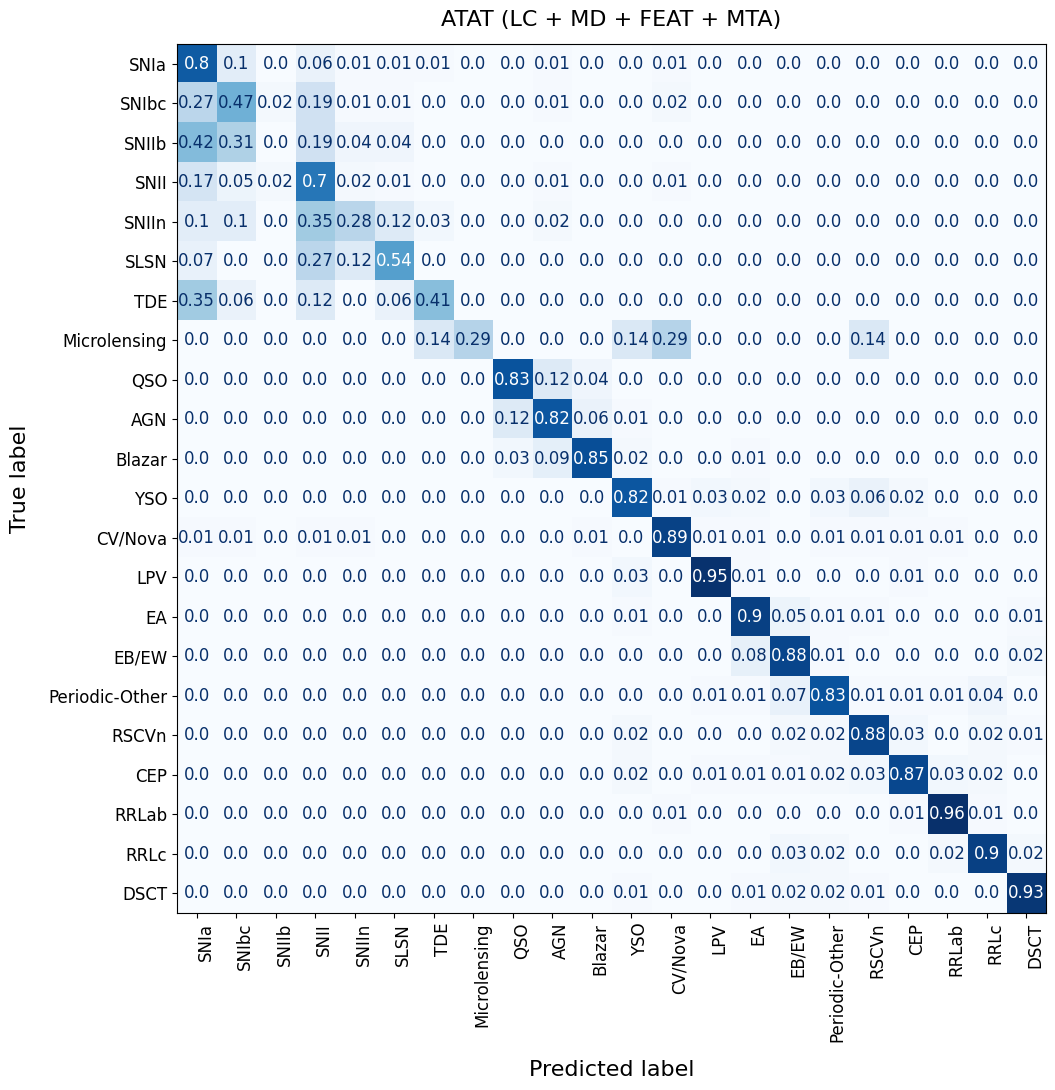

In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fs = 12

cm = confusion_matrix(y_true=y_real_test, y_pred=y_pred_test, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(11, 11)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_title('ATAT (LC + MD + FEAT + MTA)', fontsize=16, pad=13)
ax.set_xlabel('Predicted label', fontsize=16, labelpad=13)  # Label del eje x
ax.set_ylabel('True label', fontsize=16, labelpad=13)        # Label del eje y

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.show()

In [45]:
from sklearn.metrics import f1_score

f1_score(y_real_test, y_pred_test, average='macro')

0.7259295490022349